# Problem Statement


The data is available as two attached CSV files:

    -takehome_user_engagement.csv
    -takehome_users.csv

The data has the following two tables:

1. A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

    -**name**: the user's name
    
    -**object_id**: the user's id
    
    -**email**: email address
    
    -**creation_source**: how their account was created. This takes on one of 5 values:
    
        ○ PERSONAL_PROJECTS: invited to join another user's personal workspace
        ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)
        ○ ORG_INVITE: invited to an organization (as a full member)
        ○ SIGNUP: signed up via the website
        ○ SIGNUP_GOOGLE_AUTH: signed-up using Google Authentication(using a Google email account for their loginid)
        
    -**creation_time**: when they created their account
    
    -**last_session_creation_time**: unix timestamp of last login
    
    -**Opted_in_to_mailing_list**: whether they have opted into receiving marketing emails
    
    -**enabled_for_marketing_drip**: whether they are on the regular marketing email drip
    
    -**org_id**: the organization (group of users) they belong to
    
    -**invited_by_user_id**: which user invited them to join (if applicable).
       
       
2. A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

*Defining an **"adopted user"** as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.*

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. 

Please send us a brief writeup of your findings (the more concise, the better -- no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. 

Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

# Data Exploration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from time import time
import calendar
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:

from inspect import signature


In [3]:
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['axes.grid']=True
plt.rcParams["figure.figsize"] = (15,6)

In [4]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [5]:
## Data Upload

In [6]:
engage_df = pd.read_csv('takehome_user_engagement.csv')
## Nice display of info
print('_'*12,'Dataframe head','_'*12)
print('-'*40)
print(engage_df.head())
print('-'*40)
print('_'*12,'Dataframe info','_'*12)
print('-'*40)
print(engage_df.info())

____________ Dataframe head ____________
----------------------------------------
            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1
----------------------------------------
____________ Dataframe info ____________
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


<p> There were no null values in the data frame. 
The data frame had 207,817 rows and 3 columns.
First column contained the time stamps but was object type was coverted in datetime format, followed by setting it as dataframe index.</p>

In [7]:
engage_df['time_stamp'] = pd.to_datetime(engage_df['time_stamp'])
engage_df.set_index('time_stamp',inplace=True)
engage_df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [8]:
print('__'*50)
print('The data frame contained the visit counts of {} ivdivduals, out of the total {} user.'
      .format(len(engage_df.user_id.unique()),
              max(engage_df.user_id)))
print('__'*50)

____________________________________________________________________________________________________
The data frame contained the visit counts of 8823 ivdivduals, out of the total 12000 user.
____________________________________________________________________________________________________


By the definition of *active user* in the problem statement, the next task is to assing a tag to each user based on the time stamp infromation whether they are Active users or not.

The condition for a user to be active is: Must have logged in atleast three different days within a week's period.

The dataframe was grouped for each user and count the number of times the user signed in during a weeks' period.

In [9]:
df_usr_wk = engage_df.groupby('user_id').resample('1W',label = 'right').sum()
df_usr_wk.head()

user_id  visited
user_id time_stamp                  
1       2014-04-27        1        1
2       2013-11-17        2        1
        2013-11-24        0        0
        2013-12-01        2        1
        2013-12-08        0        0

In [10]:
# Drop the user_id column
df_usr_wk = df_usr_wk.drop('user_id', axis =1 )
df_usr_wk.head()

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0

In [11]:
# New column to record number of visits exceeding 3
df_usr_wk['active'] = 1*(df_usr_wk.visited >2)
df_usr_wk.head(15)

visited  active
user_id time_stamp                 
1       2014-04-27        1       0
2       2013-11-17        1       0
        2013-11-24        0       0
        2013-12-01        1       0
        2013-12-08        0       0
        2013-12-15        1       0
        2013-12-22        0       0
        2013-12-29        1       0
        2014-01-05        1       0
        2014-01-12        1       0
        2014-01-19        0       0
        2014-01-26        0       0
        2014-02-02        0       0
        2014-02-09        3       1
        2014-02-16        2       0

In [12]:
# A user can have mutiple instance of sign-in as active
# Reset the index so that user_id can be used again
active_df = df_usr_wk.reset_index(level = 0)
active_df.head(2)

,user_id,visited,active
time_stamp,,,
2014-04-27,1,1,0
2013-11-17,2,1,0


In [13]:
# Count of the number of times each user visited
active_df = active_df.groupby('user_id').sum()
active_df.head(10)

,visited,active
user_id,,
1,1,0
2,14,1
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
10,284,52
11,1,0


In [14]:
# Since the number of times an active user was active is not significant the column is
# restructured to be contain 0 is user is inactive and 1 if actice
active_df['active'] = 1*(active_df.active >0)
active_df.head(5)

,visited,active
user_id,,
1,1,0
2,14,1
3,1,0
4,1,0
5,1,0


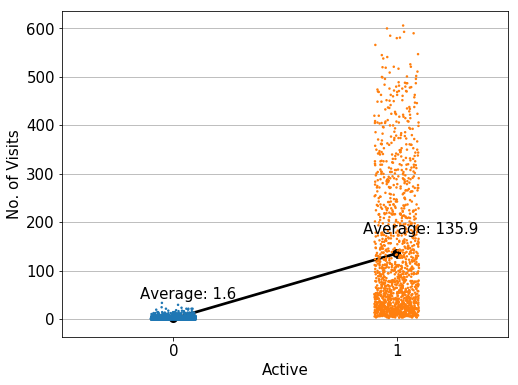

In [15]:
fig,axes = plt.subplots(1,1,figsize = (8,6))
sns.catplot(x = 'active',y = 'visited', data = active_df, ax = axes, marker = '.')
sns.catplot(x = 'active',y = 'visited', data = active_df, kind = 'point', color = 'k', ax = axes)
for i,val in enumerate(active_df.groupby('active').mean().visited):
    axes.text(i-.15, val+40, 'Average: {:.1f}'.format(val))
axes.set_ylabel('No. of Visits')
axes.set_xlabel('Active')
plt.close(2)
plt.close(3)
plt.show()

In [16]:
active_df = active_df.sort_index()

Now, the final dataframe with user ids of active users based on the time_stamp data of information was ready.
This information can be combined with the information provided with the other dataframe.

In [17]:
# UTF64 code was unable to upload the csv file, thus encoding was updated
user_df = pd.read_csv('takehome_users.csv',encoding='latin-1')
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [18]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


# Feature Analysis
## 1. Invited by User ID
ID of other user who invited the user. If not invited by another user, the column values were missing (null).

A value of zero is assigned to this. In order to study impact of this feature on the active status of user,
the column is converted into boolean object. 

Thus it would be interesting to see if the number if user who were invited by the others were more active.

In [19]:
user_df['invited_by_user_id'] = 1*(user_df['invited_by_user_id'].notnull())

## 2. Creation Source

Creation source refers to the information on  how their account was created.

 ○ PERSONAL_PROJECTS: invited to join another user's personal workspace
 
 ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)
 
 ○ ORG_INVITE: invited to an organization (as a full member)
 
 ○ SIGNUP: signed up via the website
 
 ○ SIGNUP_GOOGLE_AUTH: signed-up using Google Authentication(using a Google email account for their loginid)
 
The information in the coumn was split into 5 different one-hot encoded columns using sklearn's LabelBinarizer.

After the encoding the base colum was deleted.

In [20]:
lbs = LabelBinarizer()
creation_source = lbs.fit_transform(user_df.creation_source)
creation_df = pd.DataFrame(creation_source, columns=lbs.classes_)

In [21]:
# merge the one-hot encoded columns back in the main dataset and drop the base column
user = user_df.join(creation_df)
user = user.set_index('object_id', drop = True).sort_index()
user.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1,1,0,0,0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1,0,1,0,0,0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1,0,1,0,0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1,1,0,0,0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1,1,0,0,0,0


## 3. Creation Time

Creation time refers to when users created their account. The Creation time column was in object format and was converted into the right data-time format.
The column had total 11,996 unique values out of total 12,000 data points indicating time stamps when two users (maximum frequency per time stamp) signed exactly the same time.

Since the information in columns and email was not significant to reason for user being active the columns were deleted from the dataset afterwards.

In [22]:
user['creation_time'] = pd.to_datetime(user['creation_time'])

In [23]:
user.creation_time.describe()

count                   12000
unique                  11996
top       2014-02-11 17:57:53
freq                        2
first     2012-05-31 00:43:27
last      2014-05-30 23:59:19
Name: creation_time, dtype: object

In [24]:
user= user.drop(['name','email'],axis = 1)

In [25]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
creation_time                 12000 non-null datetime64[ns]
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int64
GUEST_INVITE                  12000 non-null int64
ORG_INVITE                    12000 non-null int64
PERSONAL_PROJECTS             12000 non-null int64
SIGNUP                        12000 non-null int64
SIGNUP_GOOGLE_AUTH            12000 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 1.2+ MB


## 4. Last Session Creation Time
Main dataset had total 12,000 rows. After the processing of columns above the column only one column was left with null values. The number of rows in the the 'last_session_creation_time" was same as the number of rows in the active user data frame, 8823. The information in the last_session_creation_time has unix time stamps of last user usage. This information was used to compute the time_invertal of users from the day account was created (creation_time).


In [26]:
user = user.dropna(axis = 0)

In [27]:
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 12 columns):
creation_time                 8823 non-null datetime64[ns]
creation_source               8823 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null int64
GUEST_INVITE                  8823 non-null int64
ORG_INVITE                    8823 non-null int64
PERSONAL_PROJECTS             8823 non-null int64
SIGNUP                        8823 non-null int64
SIGNUP_GOOGLE_AUTH            8823 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 896.1+ KB


In [28]:
# Convert the unixtime stamp into datetime format
from datetime import datetime

user['last_session_creation_time']  =  user['last_session_creation_time'].map(lambda ts:datetime.utcfromtimestamp(int(ts)).strftime('%Y-%m-%d %H:%M:%S'))

user['last_session_creation_time'] = pd.to_datetime(user['last_session_creation_time'])

In [29]:
# Compute the time interval (in seconds)
user['time_interval'] = user['last_session_creation_time'] - user['creation_time']
user['time_interval'] = [t.total_seconds() for t in user['time_interval']]
user.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,time_interval
object_id,,,,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,1,0,0,0,0,0.0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,0,1,0,0,0,11750400.0
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,0,1,0,0,0,0.0
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,1,0,0,0,0,86400.0
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,1,0,0,0,0,432000.0


In [30]:
# the main date columns are not needed
user = user.drop(['creation_time','last_session_creation_time'],axis = 1)
user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 11 columns):
creation_source               8823 non-null object
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null int64
GUEST_INVITE                  8823 non-null int64
ORG_INVITE                    8823 non-null int64
PERSONAL_PROJECTS             8823 non-null int64
SIGNUP                        8823 non-null int64
SIGNUP_GOOGLE_AUTH            8823 non-null int64
time_interval                 8823 non-null float64
dtypes: float64(1), int64(9), object(1)
memory usage: 827.2+ KB


## Data Merge

At current point, all the columns in the data set were either in integer or floating point format. The user data frame was joined with the active user daata frame that contained the information weather a under was **active or not** and the number of visits by each user.

In [31]:
udf = user.join(active_df)
udf.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,time_interval,visited,active
object_id,,,,,,,,,,,,,
1,GUEST_INVITE,1,0,11,1,1,0,0,0,0,0.0,1,0
2,ORG_INVITE,0,0,1,1,0,1,0,0,0,11750400.0,14,1
3,ORG_INVITE,0,0,94,1,0,1,0,0,0,0.0,1,0
4,GUEST_INVITE,0,0,1,1,1,0,0,0,0,86400.0,1,0
5,GUEST_INVITE,0,0,193,1,1,0,0,0,0,432000.0,1,0


In [32]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 13 columns):
creation_source               8823 non-null object
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null int64
GUEST_INVITE                  8823 non-null int64
ORG_INVITE                    8823 non-null int64
PERSONAL_PROJECTS             8823 non-null int64
SIGNUP                        8823 non-null int64
SIGNUP_GOOGLE_AUTH            8823 non-null int64
time_interval                 8823 non-null float64
visited                       8823 non-null int64
active                        8823 non-null int64
dtypes: float64(1), int64(11), object(1)
memory usage: 1.3+ MB


## 5. Orgnaization ID

Org_ID is the organization (group of users), a user belong to. Based on the plot below, the org_id column had values both in the active and non-active groups. It might be the case that users to belong to certain organizations are more more active than other. 

Activation rate per organization was computed as the number of active users divided by the total number of users(active or non-active).


In [33]:
# two dataframes containing the org_ids of active and non-active users
org_df_inactive = pd.DataFrame(udf[udf.active == 0].org_id.value_counts())
org_df_active = pd.DataFrame(udf[udf.active == 1].org_id.value_counts())

act_org = udf.groupby('org_id').sum().active/udf.groupby('org_id').count().active
act_dict = act_org.to_dict()
udf['activation_rt'] = udf['org_id'].apply(lambda i: act_dict.get(i))

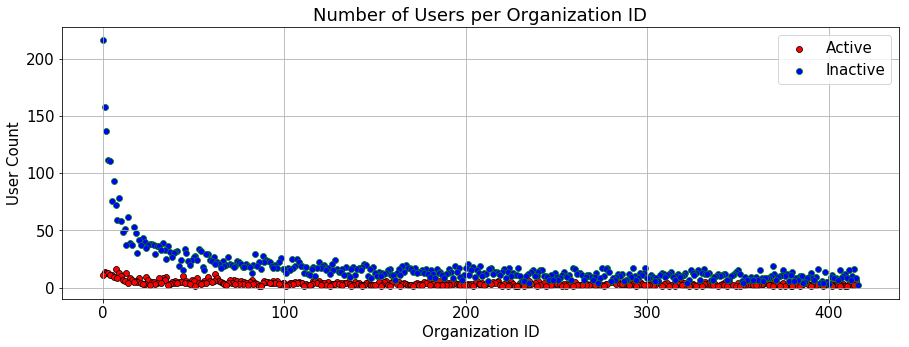

In [34]:
plt.figure(figsize = (15,5))
sns.scatterplot(org_df_active.index,org_df_active.org_id,color ='red',edgecolor="k");
sns.scatterplot(org_df_inactive.index,org_df_inactive.org_id,color ='blue',edgecolor="green");

plt.xlabel('Organization ID')
plt.ylabel('User Count')
plt.legend(['Active','Inactive'])
plt.title('Number of Users per Organization ID');

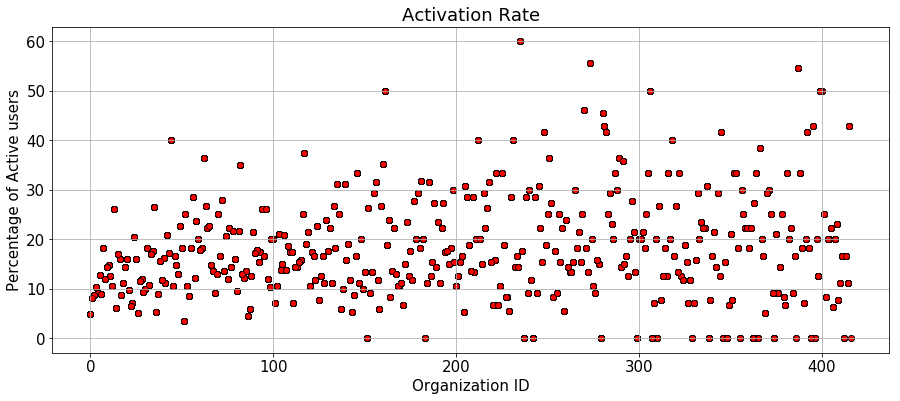

In [35]:
sns.scatterplot(udf.org_id,udf['activation_rt']*100,color ='red',edgecolor="k");
plt.xlabel('Organization ID')
plt.ylabel('Percentage of Active users');
plt.title('Activation Rate');

## 6. On Marking or Mailing List

On average the number of users in both active and inactive categories in the mailing or marking list was comparable.

Number of active used on either of lists was relatively less the total number of users.


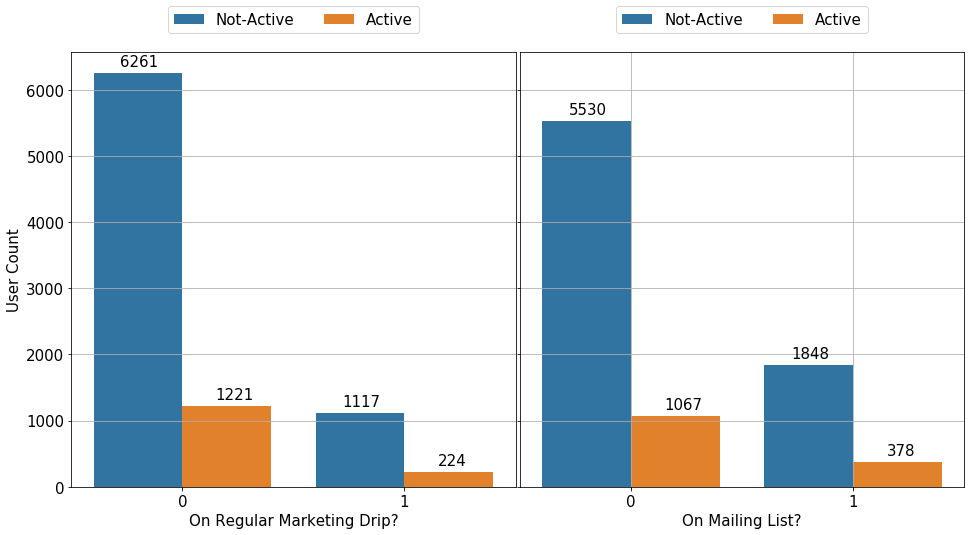

In [36]:
fig,axes = plt.subplots(1,2,figsize = (16,8),sharey = True)

for i,val in enumerate(["enabled_for_marketing_drip","opted_in_to_mailing_list"]):
    sns.countplot(x =val, hue = 'active', data = udf, ax = axes[i]);
    if i:
        axes[i].set_xlabel('On Mailing List?')
        axes[i].set_ylabel('')
    else:
        axes[i].set_xlabel('On Regular Marketing Drip?')
        axes[i].set_ylabel('User Count')
    
    axes[i].legend(['Not-Active','Active'], loc = 'upper left', ncol =2,
               bbox_to_anchor=(0.2, 1.02, 1.2, .102))
    axes[i].set_xticks([0,1],['No','Yes']);

    #count number of active/not-active users in each of the categories
    temp_count = udf.groupby(['active',val]).count()['GUEST_INVITE'].values
    for j in range(2):
        axes[i].text(j-0.28,temp_count[j]+100,temp_count[j])
        axes[i].text(j+0.15,temp_count[j+2]+100,temp_count[j+2])

    plt.grid()
plt.subplots_adjust(wspace=0.01)
plt.show()

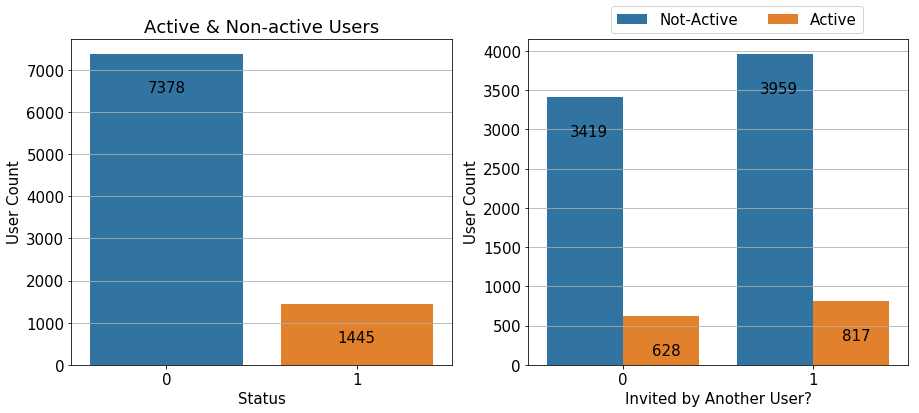

In [37]:
fig,axes = plt.subplots(1,2,figsize = (15,6))


sns.countplot(udf.active,ax = axes[0])
axes[0].set_title('Active & Non-active Users');
axes[0].set_ylabel('User Count')
axes[0].set_xlabel('Status')
axes[0].set_xticks([0,1],['Not-Active','Active']);
for i, val in enumerate(udf.active.value_counts()):
    axes[0].text(i-0.1,val-900, val)


sns.countplot(x ="invited_by_user_id", hue = 'active', data = udf, ax = axes[1]);
axes[1].set_xlabel('Invited by Another User?')
axes[1].set_ylabel('User Count')
plt.legend(['Not-Active','Active'], loc = 'upper left', ncol =2,
           bbox_to_anchor=(0.2, 1.02, 1.2, .102))
axes[1].set_xticks([0,1],['No','Yes']);

#count number of active/not-active users in each of the categories
temp_count = udf.groupby(['active',"invited_by_user_id"]).count()['GUEST_INVITE'].values
for i in range(2):
    axes[1].text(i-0.28,temp_count[i]-500,temp_count[i])
    axes[1].text(i+0.15,temp_count[i+2]-500,temp_count[i+2])

plt.show()

The data set was imbalance with only 16% of active users. The among the active users, about 56% were invited by the other user

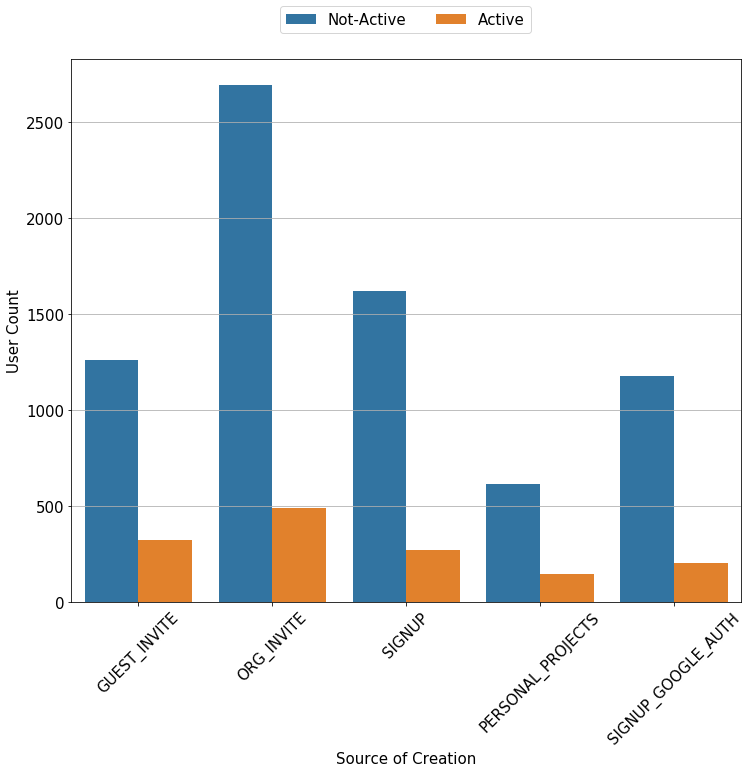

In [44]:
plt.figure(figsize = (12,10))
sns.countplot(x ="creation_source", hue = 'active', data = udf);
plt.xlabel('Source of Creation')
plt.ylabel('User Count')
plt.legend(['Not-Active','Active'], loc = 'upper left', ncol =2,
           bbox_to_anchor=(0.3, 1.01, 1.2, .10))
#plt.xticks([0,1],['No','Yes']);
plt.xticks(rotation = '45')
#count number of active/not-active users in each of the categories
temp_count = udf.groupby(['active',"creation_source"]).count()['GUEST_INVITE'].values

In [45]:
udf= udf.drop(['creation_source'],axis = 1)

# Machine Learning Model

The column with user tag as active (1) or not (0) was extracted as the label column and rest of the  data frame was used as the feature space. The final data set was split into training and test set with 2:1 split ratio.

In [46]:
# Extract the feature and labels from the data set
labels = udf['active'] 
features = udf.drop('active',axis = 1)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
print('Shape of training input: ', x_train.shape)
print('Shape of test input: ', x_test.shape)
print('Length of training labels: ', len(y_train))
print('Length of test labels: ', len(y_test))

Shape of training input:  (5911, 12)
Shape of test input:  (2912, 12)
Length of training labels:  5911
Length of test labels:  2912


# Classifier Training

Gradient Boosting Classifier was used for the binary classifiation.

The model hyper parameteres were first tuned using gridsearch. 5-fold cross validation was used to control the model overfit and validation.

The best fit model had 100 trees, 0.1 learning rate per tress and maximum tree depth of 3, that has F1-score of 95%.

In [48]:
gbmodel = GradientBoostingClassifier()
param_grid = {'n_estimators':[50,100,200],
              'learning_rate':[0.1,0.01,0.001],
              'max_depth':[1,3,5]}
best_fit = GridSearchCV(estimator=gbmodel,
                        param_grid=param_grid,
                        scoring='f1',cv=5)
best_fit.fit(x_train,y_train)
print('Best fit paratmers :',best_fit.best_params_)
print('Best fit F1-Score: {:.2f}%'.format(best_fit.best_score_*100))


Best fit paratmers : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best fit F1-Score: 95.42%


In [49]:
model = GradientBoostingClassifier(learning_rate = 0.1,max_depth = 3, n_estimators = 50)
model.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [59]:
# make predictions for test data
y_pred = model.predict(x_test)
f1score = f1_score(y_test, y_pred)
print("F1-Score (Test): {:.2f}%" .format(f1score * 100.0))

F1-Score (Test): 94.02%


In [51]:
print('_' * 80)
print("classification report:")
print(classification_report(y_test, y_pred,target_names=['Not-Active','Active']))
print('_' * 80)
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred))

________________________________________________________________________________
classification report:
              precision    recall  f1-score   support

  Not-Active       0.98      0.99      0.99      2425
      Active       0.96      0.92      0.94       487

    accuracy                           0.98      2912
   macro avg       0.97      0.96      0.96      2912
weighted avg       0.98      0.98      0.98      2912

________________________________________________________________________________
confusion matrix:
[[2407   18]
 [  39  448]]


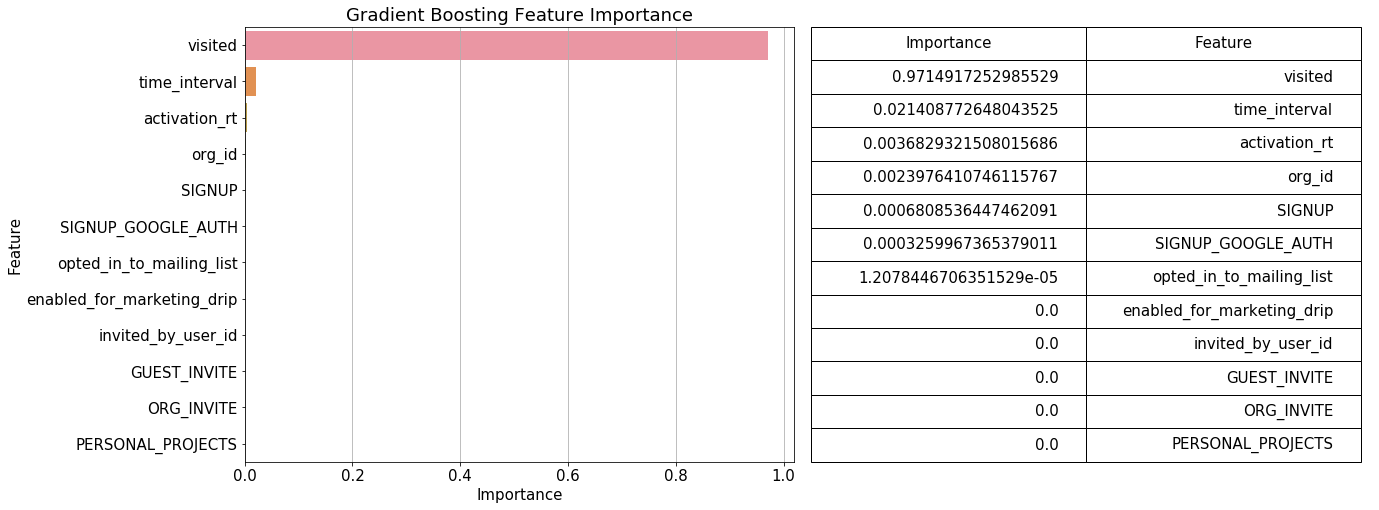

In [52]:
feat_imp = pd.DataFrame({'Importance':model.feature_importances_})    
feat_imp['Feature'] = features.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
#feat_imp = feat_imp.iloc[:11]
cell_text = []
for row in range(len(feat_imp)):
        cell_text.append(feat_imp.iloc[row])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
sns.barplot(y="Feature", x="Importance", data=feat_imp, ax = ax)
ax.set_title('Gradient Boosting Feature Importance')

ax = fig.add_subplot(122)
t1 = plt.table(cellText=cell_text, colLabels=feat_imp.columns,
                loc='center',bbox = (0,0,1,1))
ax.grid()
t1.auto_set_font_size(False)
t1.set_fontsize(15)
plt.axis('off')
plt.subplots_adjust(wspace=0.03)
plt.show()


In [53]:
average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
y_pred_prob = model.predict_proba(x_test)[:,1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

Average precision-recall score: 0.90


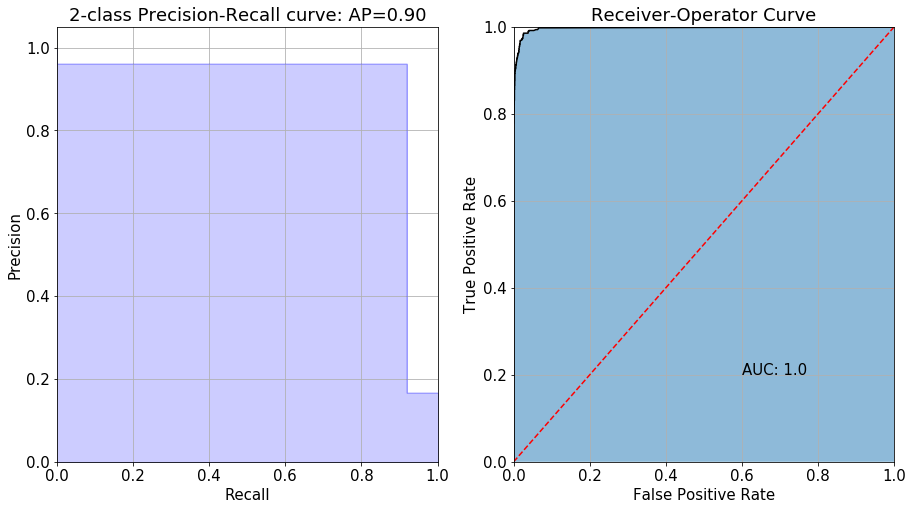

In [54]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15,8))
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
ax1.step(recall, precision, color='b', alpha=0.2,
         where='post')
ax1.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))


ax2.plot(fpr, tpr, 'k-')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.fill_between(fpr, tpr, alpha =0.5)
ax2.axis([0,1,0,1])

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver-Operator Curve')

roc_score = roc_auc_score(y_test, y_pred_prob)
ax2.text(0.6,0.2,'AUC: {}'.format(np.round(roc_score,2)));



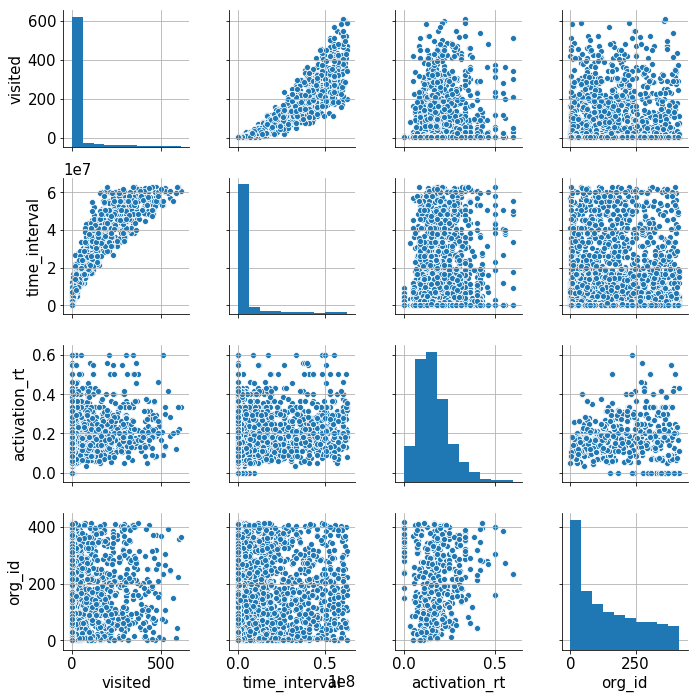

In [55]:
sns.pairplot(x_train[feat_imp.Feature[:4]])

Figure above shows the pair plot of the 4 most important festures. The number of visits were major predictors of the user was active or not. This makes sense as more visits a user makes more are the chances the user being active.
The second feature was the time interval betwteen the time time of creation and time of the last session. The first and second features had a sharp relation (a linear regression can fit). The third feature representated the rate of activation this organziations with more members had more active members.

In [57]:
y_test.value_counts()

0    2425
1     487
Name: active, dtype: int64